In [1]:
#!pip install mne
#!pip install torch-scatter
#!pip install torch-sparse
#!pip install torch-geometric

#from google.colab import drive
#drive.mount('/content/drive/')

import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.spatial import Delaunay
import networkx as nx
import scipy.sparse as sp
import time
from sklearn.neighbors import NearestNeighbors

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import Scaler

#from torch_geometric.data import Data, InMemoryDataset
#import torch
#from torch import nn, optim
#from torch.optim.lr_scheduler import StepLR
#from torch.utils.data import Dataset, DataLoader
#from torch.nn import functional as F

In [2]:
DATA_PATH = '/content/drive/MyDrive/Sidorov_Diploma/p300_detection/BCI_Comp_III_Wads_2004/'

train_A_raw = scipy.io.loadmat('../p300_speller_dataset/Subject_A_Train.mat')
train_B_raw = scipy.io.loadmat('../p300_speller_dataset/Subject_B_Train.mat')
test_A_raw = scipy.io.loadmat('../p300_speller_dataset/Subject_A_Test.mat')
test_B_raw = scipy.io.loadmat('../p300_speller_dataset/Subject_B_Test.mat')

eloc = mne.channels.read_custom_montage('../p300_speller_dataset/eloc64.loc')

In [ ]:
X = []
y = []

for epoch_num in tqdm(range(len(train_A_raw['Flashing']))):
    epoch_flash = train_A_raw['Flashing'][epoch_num]
    idx = np.where(epoch_flash[:-1] != epoch_flash[1:])[0][1::2] + 1
    idx_t = np.where(epoch_flash[:-1] != epoch_flash[1:])[0] + 1
    
    res = train_A_raw['Signal'][epoch_num].T
    res = np.split(res.T, idx, axis=0)
    target = train_A_raw['StimulusType'][epoch_num][np.insert(idx_t, 0, 0)]

    target = target[::2]
    res[-1] = res[-1][:42]

    X.append(res)
    y.append(target)

X = np.transpose(np.concatenate(X), (0, 2, 1))
y = np.concatenate(y)

In [3]:
epoch_num = 0

epoch_flash = train_A_raw['Flashing'][epoch_num]
idx = np.where(epoch_flash[:-1] != epoch_flash[1:])[0][1::2] + 1
idx_t = np.where(epoch_flash[:-1] != epoch_flash[1:])[0] + 1

res = train_A_raw['Signal'][epoch_num].T
res = np.split(res.T, idx, axis=0)
target = train_A_raw['StimulusType'][epoch_num][np.insert(idx_t, 0, 0)]

target = target[::2]
res[-1] = res[-1][:42]

In [73]:
3897 / 85

45.84705882352941

In [37]:
train_A_raw['StimulusType'][epoch_num]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [59]:
info = mne.create_info(ch_names=eloc.ch_names, ch_types=['eeg'] * 64, sfreq=240)

In [239]:
def filter(X, freq=120):
    train_array = mne.io.RawArray(X.T, info, verbose=False)
    train_array.set_montage(eloc)
    return train_array.filter(1, 20, method='fir', verbose=False).resample(freq, verbose=False).get_data() # .resample(120, verbose=False)

In [228]:
def resample(X, freq=120):
    train_array = mne.io.RawArray(X.T, info, verbose=False)
    train_array.set_montage(eloc)
    return train_array.resample(freq, verbose=False).get_data().T

In [229]:
res[3].shape

(144, 64)

In [230]:
resample(res[3]).shape

(72, 64)

In [240]:
row_dict = []
row_dict += list(zip(['A', 'B', 'C', 'D', 'E', 'F'], [7] * 6))
row_dict += list(zip(['G', 'H', 'I', 'J', 'K', 'L'], [8] * 6))
row_dict += list(zip(['M', 'N', 'O', 'P', 'Q', 'R'], [9] * 6))
row_dict += list(zip(['S', 'T', 'U', 'V', 'W', 'X'], [10] * 6))
row_dict += list(zip(['Y', 'Z', '1', '2', '3', '4'], [11] * 6))
row_dict += list(zip(['5', '6', '7', '8', '9', '_'], [12] * 6))

row_dict = dict(row_dict)

col_dict = []
col_dict += list(zip(['A', 'G', 'M', 'S', 'Y', '5'], [1] * 6))
col_dict += list(zip(['B', 'H', 'N', 'T', 'Z', '6'], [2] * 6))
col_dict += list(zip(['C', 'I', 'O', 'U', '1', '7'], [3] * 6))
col_dict += list(zip(['D', 'J', 'P', 'V', '2', '8'], [4] * 6))
col_dict += list(zip(['E', 'K', 'Q', 'W', '3', '9'], [5] * 6))
col_dict += list(zip(['F', 'L', 'R', 'X', '4', '_'], [6] * 6))

col_dict = dict(col_dict)

info = mne.create_info(ch_names=eloc.ch_names, 
                           ch_types=['eeg'] * 64, 
                           sfreq=240)

def filter(X):
    train_array = mne.io.RawArray(X.T, info, verbose=False)
    train_array.set_montage(eloc)
    return train_array.filter(1,20, method='iir', verbose=False).get_data()

def p300_set(raw_data, sample_size=72, target_chars=None):
    X = []
    y = []

    for epoch_num in range(len(raw_data['Flashing'])):
        epoch_flash = raw_data['Flashing'][epoch_num]
        idx = np.where(epoch_flash[:-1] != epoch_flash[1:])[0][1::2] + 1
        idx = np.concatenate([[0], idx])
        
        data = raw_data['Signal'][epoch_num] #filter(raw_data['Signal'][epoch_num])
        res = []
        for i in idx:
            res.append(data[i:i+sample_size])

        if target_chars:
            rows = (raw_data['StimulusCode'][epoch_num][idx] == row_dict[target_chars[epoch_num]]).astype(int)
            cols = (raw_data['StimulusCode'][epoch_num][idx] == col_dict[target_chars[epoch_num]]).astype(int)

            target = rows + cols
        else:
            target = raw_data['StimulusType'][epoch_num][idx]

        X.append(res)
        y.append(target)

    X = np.transpose(np.concatenate(X), (0, 2, 1))
    y = np.concatenate(y)

    return X, y

In [212]:
target = train_A_raw['StimulusType'][0][idx]
target.shape

(180,)

In [210]:
rows = (test_A_raw['StimulusCode'][epoch_num][idx] == row_dict[test_A_chars[epoch_num]]).astype(int)
cols = (test_A_raw['StimulusCode'][epoch_num][idx] == col_dict[test_A_chars[epoch_num]]).astype(int)

target = rows + cols

In [211]:
target.sum()

30

In [204]:
target

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1])

In [203]:
len(target)

180

In [180]:
target

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [196]:
train_A_chars = list(train_A_raw['TargetChar'][0])
train_B_chars = list(train_B_raw['TargetChar'][0])
test_A_chars = list('WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU')
test_B_chars = list('MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR')

In [238]:
train_array = mne.io.RawArray(X_train_A, info, verbose=False)
train_array.set_montage(eloc)
train_array.resample(120, verbose=False).get_data()

ValueError: Data must be a 2D array of shape (n_channels, n_samples), got shape (15300, 64, 144)

In [ ]:
X_train_A, y_train_A = p300_set(train_A_raw) 

In [241]:
X_train_A, y_train_A = p300_set(train_A_raw) # , target_chars=train_A_chars
X_train_B, y_train_B = p300_set(train_B_raw) # , target_chars=train_B_chars
X_test_A, y_test_A = p300_set(test_A_raw, target_chars=test_A_chars)
X_test_B, y_test_B = p300_set(test_B_raw, target_chars=test_B_chars)

In [242]:
X_train_A.shape

(15300, 64, 72)

In [192]:
epoch_flash = train_A_raw['Flashing'][0]
idx = np.where(epoch_flash[:-1] != epoch_flash[1:])[0][1::2] + 1
idx = np.concatenate([[0], idx])
idx_t = np.where(epoch_flash[:-1] != epoch_flash[1:])[0] + 1
idx_t = np.concatenate([[0], idx_t])

In [176]:
data = train_A_raw['Signal'][epoch_num] #filter(raw_data['Signal'][epoch_num])
#res = np.split(res.T, idx, axis=0)
res = []
for i in idx:
    res.append(data[i:i+144])

res[3].shape

(144, 64)

In [175]:
res = train_A_raw['Signal'][epoch_num].T#filter(raw_data['Signal'][epoch_num])
res = np.split(res.T, idx, axis=0)

res[3].shape

(42, 64)

In [188]:
train_A_raw['StimulusCode'][73][idx]

array([ 6.,  6.,  9.,  2.,  4.,  5.,  1., 10., 11.,  8.,  7.,  3., 12.,
        6.,  2., 11., 12.,  7.,  3., 10.,  4.,  1.,  9.,  5.,  8.,  1.,
        6.,  3.,  9.,  7., 10.,  8., 11.,  5.,  4.,  2., 12.,  6., 10.,
       12.,  4.,  5., 11.,  1.,  7.,  9.,  2.,  8.,  3.,  8.,  5.,  6.,
        3.,  4.,  7., 10.,  9., 12., 11.,  1.,  2.,  4.,  6.,  5.,  8.,
        7.,  1.,  3., 10., 11., 12.,  2.,  9.,  2.,  1.,  9., 10.,  8.,
        7.,  6.,  3., 11.,  4., 12.,  5.,  6.,  3.,  2., 10.,  9.,  4.,
        5.,  1., 11., 12.,  7.,  8., 11., 12., 10.,  1.,  3.,  5.,  8.,
        2.,  7.,  6.,  9.,  4., 10.,  5.,  8.,  7.,  6., 12.,  9.,  4.,
       11.,  1.,  3.,  2., 12.,  7., 10.,  9., 11.,  1.,  5.,  3.,  4.,
        6.,  8.,  2.,  9.,  7.,  5., 10.,  1., 12., 11.,  4.,  6.,  8.,
        2.,  3.,  2.,  3.,  8., 12.,  4.,  7., 11.,  6.,  1., 10.,  9.,
        5.,  6.,  3.,  2., 10.,  1.,  4.,  5., 11., 12.,  8.,  9.,  7.,
        3., 12.,  6.,  9.,  5.,  8.,  4.,  1.,  2.,  7., 10., 11

In [193]:
len(idx)

180

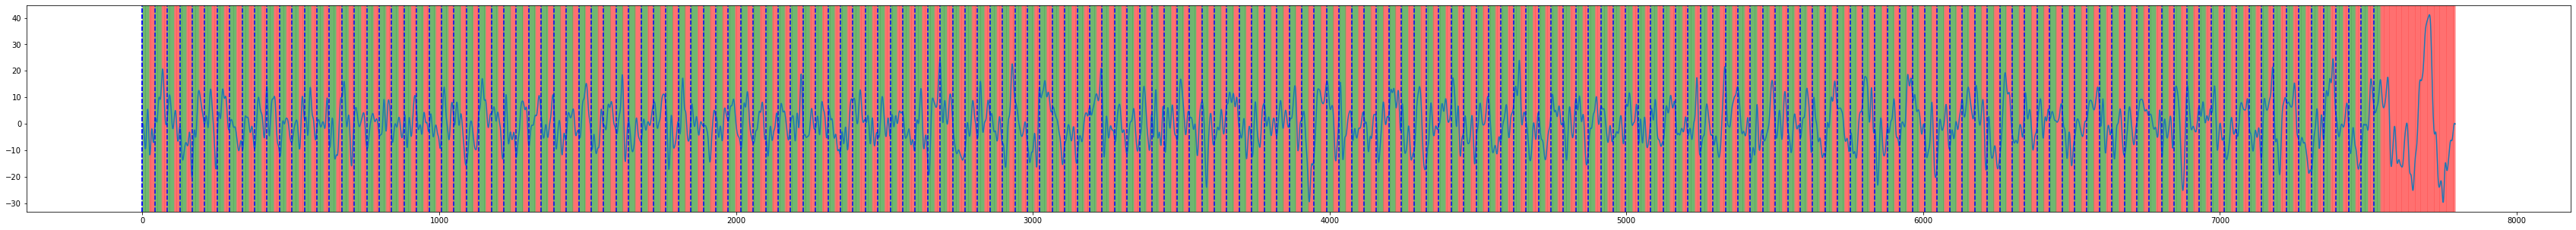

In [181]:
plt.figure(figsize=(60, 5))

for i in range(0, 7794):
    if train_A_raw['Flashing'][epoch_num][i] == 0:
        c = 'r'
    else:
        c = 'g'
    plt.axvline(i, c=c, alpha=0.2)

plt.plot(filter(train_A_raw['Signal'][epoch_num])[10])
for i in idx:
    plt.axvline(i, c='b', ls='--')

#for i in idx_t:
#    plt.axvline(i, c='r', ls='--')

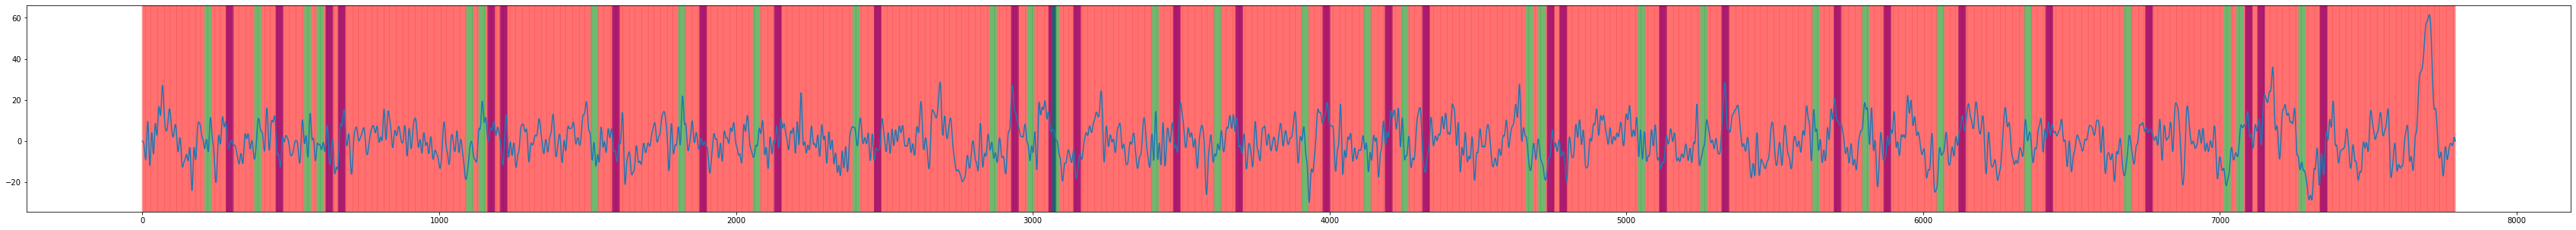

In [98]:
plt.figure(figsize=(60, 5))
for i in range(0, 7794):
    if train_A_raw['StimulusType'][epoch_num][i] == 0:
        c = 'r'
    else:
        c = 'g'
        plt.axvline(i + 72, c='b', alpha=0.3)
    plt.axvline(i, c=c, alpha=0.2)

plt.plot(filter(train_A_raw['Signal'][epoch_num])[10])
#for i in range(0, 7794, 92):
#    plt.axvline(i, c='b', ls='--')

In [96]:
600 * 240 / 1000

144.0

In [93]:
res = 0
for i in train_A_raw['Flashing'][epoch_num][::-1]:
    res += not i
    if i == 1:
        break

res

252

In [94]:
252 / 240 * 1000

1050.0

In [169]:
600 / 1000 * 240

144.0

In [85]:
24 / 240 * 1000

100.0

In [87]:
res = 0
for i in train_A_raw['Flashing'][epoch_num][24:]:
    res += not i
    if i == 1:
        break

res

18

In [88]:
18 / 240 * 1000

75.0

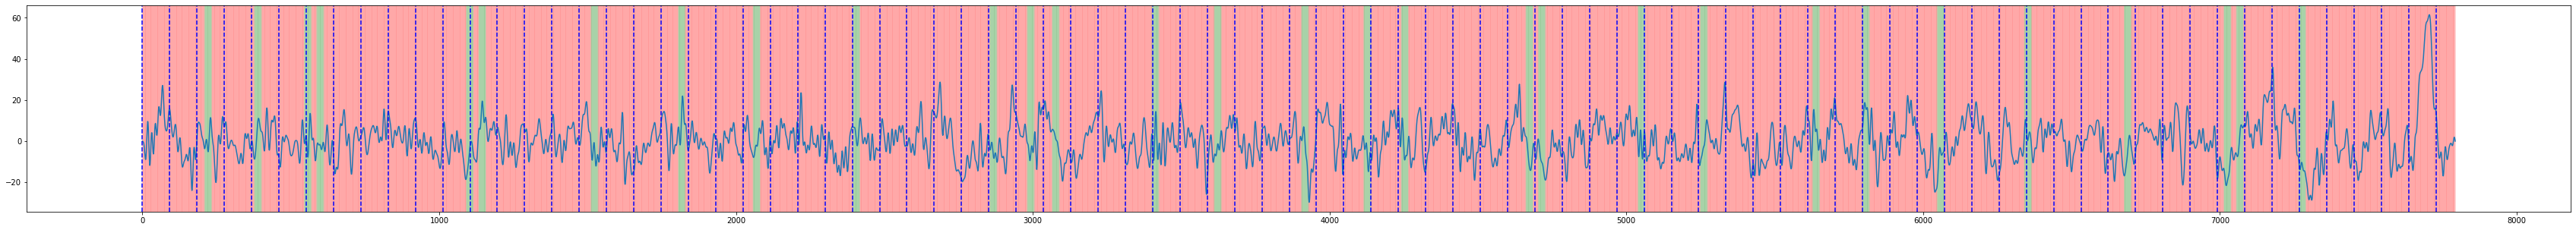

In [67]:
plt.figure(figsize=(60, 5))
for i in range(0, 7794):
    if train_A_raw['StimulusType'][epoch_num][i] == 0:
        c = 'r'
    else:
        c = 'g'
    plt.axvline(i, c=c, alpha=0.1)

plt.plot(filter(train_A_raw['Signal'][epoch_num])[10])
for i in range(0, 7794, 92):
    plt.axvline(i, c='b', ls='--')

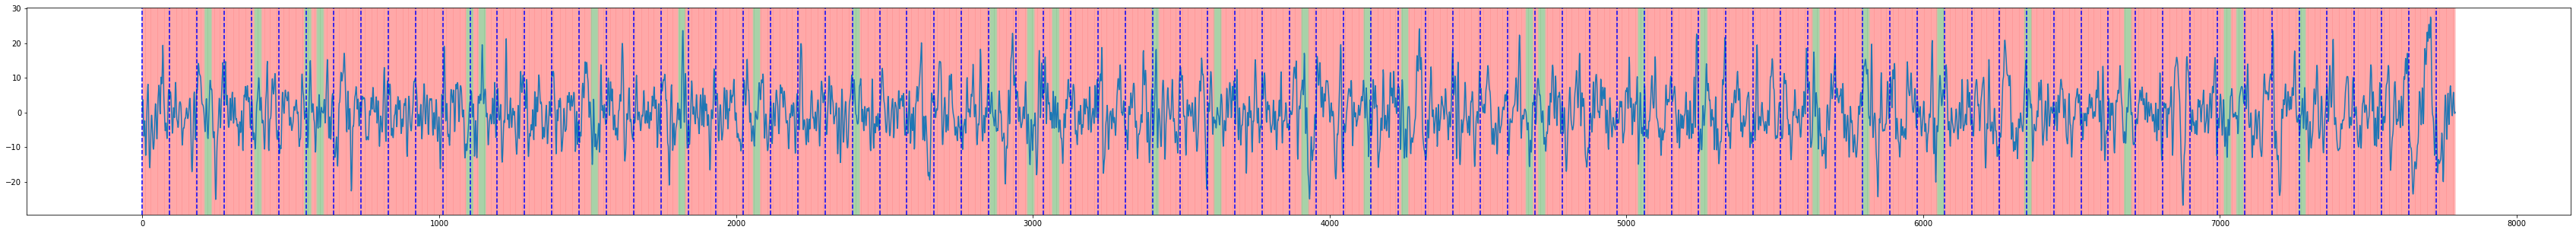

In [58]:
plt.figure(figsize=(60, 5))
for i in range(0, 7794):
    if train_A_raw['StimulusType'][epoch_num][i] == 0:
        c = 'r'
    else:
        c = 'g'
    plt.axvline(i, c=c, alpha=0.1)

plt.plot(filter(train_A_raw['Signal'][epoch_num])[10])
for i in range(0, 7794, 92):
    plt.axvline(i, c='b', ls='--')

In [118]:
(7794 / 240 * 1000 - 2000) / 15 / 12

169.30555555555557

In [113]:
7794 / 240

32.475

In [126]:
def get_motor_subject(subject = 1):
    tmin, tmax = -1., 4.
    event_id = dict(hands=2, feet=3)
    runs = [6, 10, 14]  # motor imagery: hands vs feet

    raw_fnames = eegbci.load_data(subject, runs, verbose=False, update_path=True)
    raw = concatenate_raws([read_raw_edf(f, preload=True, verbose=False) for f in raw_fnames], verbose=False)
    eegbci.standardize(raw)  # set channel names
    montage = make_standard_montage('standard_1005')
    raw.set_montage(montage)

    # strip channel names of "." characters
    raw.rename_channels(lambda x: x.strip('.'))

    # Apply band-pass filter
    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge', verbose=False)

    events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3), verbose=False)

    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

    # Read epochs (train will be done only between 1 and 2s)
    # Testing will be done with a running classifier
    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True, verbose=False)
    epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
    labels = epochs.events[:, -1] - 2

    return epochs_train.get_data(), labels

In [127]:
second_data = get_motor_subject()

In [128]:
second_data[0][1]

array([[-6.27576188e-06, -5.82008405e-07,  3.63030896e-06, ...,
        -1.66813520e-05, -1.41266917e-05, -1.17255292e-05],
       [-3.42076611e-06, -1.68350965e-06, -1.67066580e-06, ...,
        -1.58844609e-05, -1.96338345e-05, -1.86997456e-05],
       [-2.62018000e-06, -2.79493022e-06, -6.54378868e-06, ...,
        -1.19957090e-05, -1.71531124e-05, -1.80341671e-05],
       ...,
       [-2.72715346e-06, -6.18855931e-06, -4.52639699e-06, ...,
        -5.19281952e-05, -3.76914035e-05, -2.22087946e-05],
       [ 4.41640793e-06, -3.53829543e-06, -1.03985255e-05, ...,
        -4.09681967e-05, -3.72541159e-05, -2.24032210e-05],
       [-1.07453062e-05, -7.80007527e-06,  1.60217450e-06, ...,
        -4.78333245e-05, -3.36858943e-05, -1.86919237e-05]])

In [130]:
len(second_data[1])

45